# RTP anomaly

This code calculates the RTP anomaly of the simple model data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl, myv
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from matplotlib.mlab import normpdf

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun
import mag_sphere_functions as sf

# Input

In [3]:
# output of inversion
inversion = dict()

In [4]:
data = pd.read_csv('anitapolis_decimated_tfa_residual_cut.txt', skipinitialspace=True, delim_whitespace=True)

In [5]:
data['GPSALT'] = - data['GPSALT'] + 800

In [6]:
mask = (data['GPSALT'].get_values()<0.)
data = data[mask]

In [7]:
xp = data['X'].get_values()
yp = data['Y'].get_values()
zp = data['GPSALT'].get_values()
alt = data['ALTURA'].get_values()
dobs = data['mag_res1'].get_values()

## Calculating the RTP anomaly

In [8]:
zc = np.zeros_like(xp) + 800

inc, dec = [-37.05, -18.17]
incs = -21
decs = -11

A = sf.sm_tf_sphere(xp, yp, zp, xp, yp, zc, inc, dec, incs, decs)

In [9]:
mu = 1.e-2*np.trace(np.dot(A.T, A))/xp.size
lp = np.linalg.solve(np.dot(A.T,A) + mu*np.identity(xp.size), np.dot(A.T,dobs))

In [10]:
dp = np.dot(A, lp)

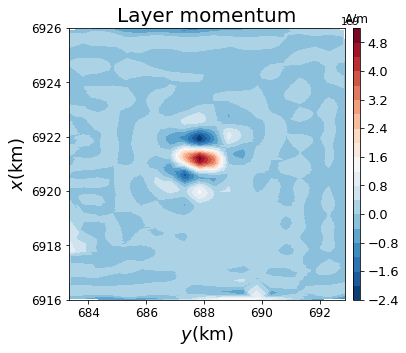

In [11]:
plt.figure(figsize=(6,5))

plt.title('Layer momentum', fontsize=20)
plt.tricontourf(yp, xp, lp, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('A/m')
mpl.m2km()

plt.show()

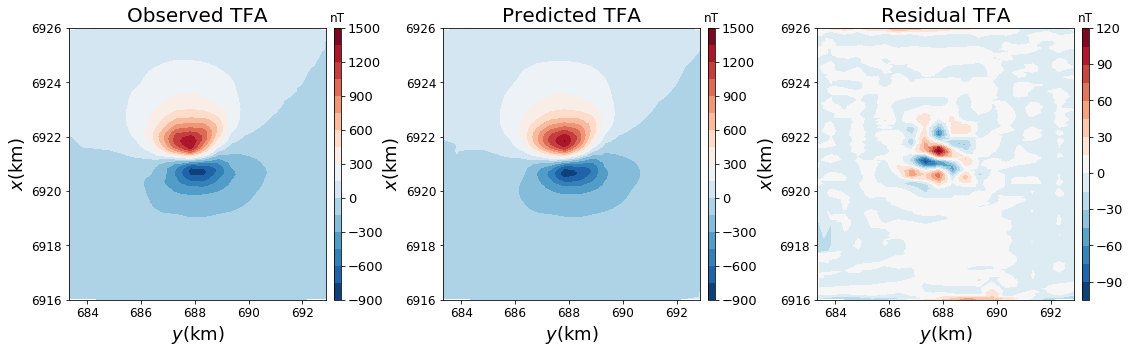

In [12]:
plt.figure(figsize=(19,5))

plt.subplot(131)
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()

plt.subplot(132)
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, dp, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()

plt.subplot(133)
plt.title('Residual TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs - dp, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
mpl.m2km()

plt.show()

In [13]:
G = sf.sm_tf_sphere(xp, yp, zp, xp, yp, zc, 90., 0., 90., 0.)

In [14]:
rtp = np.dot(G, lp)

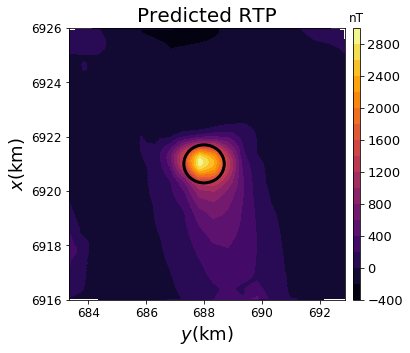

In [15]:
plt.figure(figsize=(6,5))

x0 = 6921000.
y0 = 688000.

ax = plt.subplot(111)
plt.title('Predicted RTP', fontsize=20)
circle1 = plt.Circle((y0, x0), 700, color='k', linewidth=3., fill=False)
plt.tricontourf(yp, xp, rtp, 20, cmap='inferno').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
clb.ax.set_title('nT')
ax.add_artist(circle1)
mpl.m2km()

plt.show()

In [16]:
80*24

1920